# Initialization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [4]:
sns.set_context('talk')

# Load data

In [5]:
train = pd.read_pickle('train')

# Merge dates and traps

In [6]:
train_comb = pd.DataFrame(columns=train.columns)
temp_row = train.iloc[0].copy()
# Initialize empty data frame that will hold the data merged by date and trap

# Check each row, and if it's a new date or trap, create a new row
for row in range(1, train.shape[0]):
    if (temp_row.Date != train.iloc[row].Date or
            temp_row.Trap != train.iloc[row].Trap):
        train_comb = train_comb.append(temp_row, ignore_index=True)
        temp_row = train.iloc[row].copy()

# If it's the same date and trap, add to total mosquito count
# and take the max of WnvPresent to preserve virus detection
    else:
        temp_row['NumMosquitos'] += train.iloc[row].NumMosquitos
        temp_row['WnvPresent'] = max(temp_row.WnvPresent,
                                     train.iloc[row].WnvPresent)

# Prepare data

In [7]:
# Target is whether the virus is detected
y = pd.to_numeric(train_comb.WnvPresent.values)

In [8]:
# Only use number of mosquitos for prediction
X = train_comb.NumMosquitos.astype(float).values.reshape(-1, 1)

In [9]:
# Split the data into train and test sets
# Stratify on y to guarantee instances of virus detection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y)

In [10]:
# Use borderline SMOTE to create synthetic data
# to fix the class imbalance
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X_train, y_train)

# Fit logistic regression

In [11]:
# Train logistic regression on number of mosquitos
clf = LogisticRegressionCV(random_state=42)
clf.fit(X_resampled, y_resampled)

# Calculate log loss on predictions
clf_probs = clf.predict_proba(X_test)
sig_score = log_loss(y_test, clf_probs)

# Get predicted target by setting threshold
threshold = .5
y_pred = [1 if x > threshold else 0 for x in clf_probs[:,1]]

# Print and plot metrics

In [12]:
print(sig_score)

0.617803315565


In [13]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.89      0.92      1058
          1       0.31      0.57      0.40        96

avg / total       0.90      0.86      0.88      1154



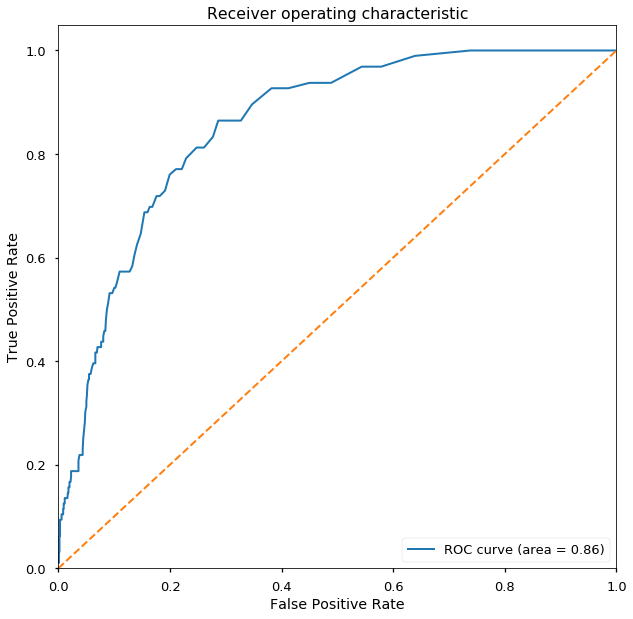

In [14]:
# Create roc_curve, calculate auc, and plot

y_score = clf.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 10))
lw = 2
ax.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")
plt.show()
fig.savefig(join('plots', 'moslogreg', 'ROC.png'))

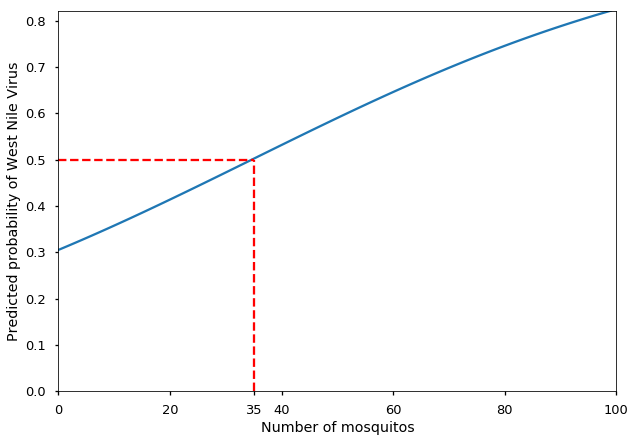

In [15]:
x = range(100)
y = [y_[0][1] for y_ in [clf.predict_proba(x_) for x_ in x]]

idx = (np.abs(np.array(y)-.5)).argmin()

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(x, y)
ax.set_xlim(0, 100)
ax.set_ylim(0, max(y))
ax.axhline(.5, xmax=x[idx]/100, c='r', ls='--')
ax.axvline(x[idx], ymax=.5/max(y), c='r', ls='--')

ax.set_xticks(list(ax.get_xticks()) + [x[idx]])

ax.set_xlabel('Number of mosquitos')
ax.set_ylabel('Predicted probability of West Nile Virus')
plt.show()
fig.savefig(join('plots', 'moslogreg', 'prediction.png'))